In [1]:
import astropy.io.fits as fits
import copy as copy
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import saphires as saph
import time as t
from astropy import units as u
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.nddata import NDData, CCDData
from astropy.stats import gaussian_sigma_to_fwhm, sigma_clipped_stats
from astropy.table import Table
from astropy.time import Time
from astropy.visualization import simple_norm, ZScaleInterval, SqrtStretch, ImageNormalize
from astropy.wcs import WCS
from astroquery.astrometry_net import AstrometryNet
from ccdproc import Combiner
from matplotlib.backends.backend_pdf import PdfPages
from photutils import aperture_photometry, CircularAperture, EPSFBuilder, CircularAnnulus
from photutils.background import MMMBackground
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import IterativelySubtractedPSFPhotometry, DAOGroup, extract_stars
from scipy.optimize import curve_fit
matplotlib.rcParams.update({'font.size': 12})
%matplotlib inline
ra = 73.59863195295
dec = +17.16480415593
pmra = -2.222
pmdec = -12.554
plx  = 6.9628
epoch = 2016.0

In [9]:
def import_images(im_list, p):
    '''
    A function that imports the data from an image file, following a given
    path to find the image file
    
        Paramters
        ---------
        im_list: list
            List containing the names of the image files
        p: string
            The pathway the script should follow to find the image
            files on the computer

        Returns
        -------
        im_data: list
            A list of the data arrays containing the pixel data
            of images
        in_headers: list
            A list of all the image headers
    '''
    im_data = []
    im_headers = []
    for i in im_list:
        path = p + i
        hdu = fits.open(path)
        data = hdu[1].data
        header = hdu[1].header
        im_data.append(data)
        im_headers.append(header)
    
    return im_data, im_headers

def find_fwhm(image, size=100):
    '''
    Fits a 2D gaussian surface to the brightest, non-saturated star
    on an image
    
        Parameters
        ----------
        image: array-like
            raw pixel data from the image
        size: integer
            radius of the cutout around the star
        
        Returns
        -------
        popt: list
            list of all the best fit values of the gaussians parameters:
            x0, y0, sig_x, sig_y, Amplitude, offset (background estimate)
    '''
    mean_val, median_val, std_val = sigma_clipped_stats(image, sigma=2.0)
    max_peak = np.max(image)
    while max_peak >= 0:
        r, c = np.where(image==max_peak)[0][0], np.where(image==max_peak)[1][0]
        star = image[r-size:r+size,c-size:c+size]
        x = np.arange(2*size)
        y = np.arange(2*size)
        X, Y = np.meshgrid(x, y)
        def gaussian(M, x0, y0, sig_x, sig_y, A, off):
            x, y = M
            return A * np.exp(-((x-x0)**2)/(2*sig_x**2)-((y-y0)**2)/(2*sig_y**2)) + off
        xdata = np.vstack((X.ravel(), Y.ravel()))
        ydata = star.ravel()
        p = [size, size, 3, 3, 10000, median_val]
        popt, pcov = curve_fit(f=gaussian, xdata=xdata, ydata=ydata, p0=p)
        im_sig = np.mean(popt[2:4])
        fwhm = im_sig*gaussian_sigma_to_fwhm
        if max_peak < 50000 and fwhm > 2:
            break
        image[r-size:r+size,c-size:c+size] = 0
        max_peak = np.max(image)
    
    return fwhm, im_sig

def find_stars(image, sigma, peak=100000):
    '''
    Searches data from an image to find objects above a given brightness
    threshold based off parameters of the ccd chip
        
        Parameters
        ----------
        image: array-like
            Array containing the intensity of light for each pixel
            on the ccd chip
        sigma: float
            sets the size tolerance for detected objects. Usually
            5.0, more than 5 is statistically unreasonable
        peak: int
            The max number of counts the chip can handle before the 
            image starts to smear. Usual ccd can handle 100,000 counts
            
        Returns
        -------
        stars: table
            A table containing all the found stars and their parameters:
            id, xcentroid, ycentroid, sharpness, roundness, npix, sky,
            peak, flux, mag
    '''
    sigma_psf = sigma
    mean_val, median_val, std_val = sigma_clipped_stats(image, sigma=2.0)
    bkg = median_val
    daofind = DAOStarFinder(fwhm=sigma_psf*gaussian_sigma_to_fwhm, threshold=bkg+10*std_val, sky=bkg, peakmax=peak, exclude_border=True)
    stars = daofind(image)
    return stars

def calculate_shift(stars1, stars2):
    '''
    Calculates the necessary shift of one image in order to be aligned 
    with a second image
    
        Parameters
        ----------
        stars1: table
            The table returned from using find_stars on an image
        stars2: table
            Same as stars1, for a different image
        
        Returns
        -------
        diff: table
            Table containing the x, y, and total offset of each star object
            found between two images
    '''
    diff = np.zeros([stars1['xcentroid'].size, 3])*np.nan
    for i in range(stars1['xcentroid'].size):
        dx = stars1['xcentroid'][i] - stars2['xcentroid']
        dy = stars1['ycentroid'][i] - stars2['ycentroid']
        distances = np.abs(np.sqrt((dx)**2 + (dy)**2))
        match = (distances == np.min(distances))
        if distances[match] < 20:
            diff[i, 0] = distances[match]
            diff[i, 1] = dx[match]
            diff[i, 2] = dy[match]
               
    return diff


def roll_image(image, diff, threshold=0.5):
    '''
    Averages the x and y offset of objects on 2 images to the nearest 
    integer, and then rolls the image by that number of pixels along each
    axis. Good for aligning two images
        
        Parameters
        ----------
        image: array-like
            Array containing the intensity of light for each pixel
            on the ccd chip
        diff: table
            Table containing the x, y, and total offset of each star object
            found between two images
        threshold: float
            The minimum pixel offset between images to allow shifting,
            usually 0.5 pixels
            
        Returns
        -------
        image_shift: array-like
            The "rolled" version of the same image, now aligned to another
            reference image
    '''
    offset = np.median(diff[:, 0])
    if offset >= threshold:
        xshift = np.median(diff[:, 1])
        yshift = np.median(diff[:, 2])
        xshift_int = np.int(np.round(xshift, 0))
        yshift_int = np.int(np.round(yshift, 0))
        image_shift = np.roll(image, (yshift_int, xshift_int), axis = (0, 1))
    
        return image_shift
    else:
        return image
    

def median_combiner(images):
    '''
    Function that takes the median of multiple images containing the
    same stars objects
        
        Parameters
        ----------
        images: list
            A list of the data arrays containing the pixel data
            of images
        
        Returns
        -------
        median_image: array-like
            Array containing the median intensity of light for each 
            pixel for a set of images
    '''
    ccd_image_list = []
    
    for image in images:
        ccd_image = CCDData(image, unit=u.adu)
        ccd_image_list.append(ccd_image)
        
    c = Combiner(ccd_image_list)
    c.sigma_clipping(func = np.ma.median)
    median_image = c.median_combine()
    median_image = np.asarray(median_image)
    
    return median_image

def image_combiner(im_data, im_sig):
    '''
    Returns a median combination of a list of images
    
        Parameters
        ----------
        im_data: list
            contains all the image data from the image set
        im_sig: float
            an image customized size parameter for searching an
            image for stars
        
        Returns
        -------
        median_image: array-like
    '''  
    stars = []
    for i in im_data:
        s = find_stars(image=i, sigma=im_sig, peak=100000)
        stars.append(s)
    if s is None:
        median_image = None
        return median_image
    else:
        diffs = []
        for s in range(len(stars)):
                diff = calculate_shift(stars1=stars[0], stars2=stars[s])
                diffs.append(diff)
        images = []
        for i in range(len(im_data)):
            image_shift = roll_image(image=im_data[i], diff=diffs[i], threshold=0.5)
            images.append(image_shift)
        median_image = median_combiner(images=images)
        
        return median_image

def image_mask(image, sources, fwhm, bkg, bkg_std):
    '''
    Masking routine that rejects stars too close to the edge of the
    image, too close to each other, and the 5 brightest and 5 dimmest
    stars in the image
    
        Parameters
        ----------
        image: array-like
            raw pixel data from the image
        sources: Table
            contains all the data aquired from the star searching routine
        fwhm: float
            used for scaling the mask based on how focused the image is
            
        Returns
        -------
        stars_tbl: Table
            condensed form of the sources table, excluding all the masked
            stars. columns: xcentroid, ycentroid, flux, peak, id
    '''
    size = 100
    hsize = (size - 1) / 2
    x = sources['xcentroid']  
    y = sources['ycentroid']
    flux = sources['flux']
    i = sources['id']
    p = sources['peak']
    mask = ((x > hsize) & (x < (image.shape[1] - 1 - hsize)) &
            (y > hsize) & (y < (image.shape[0] - 1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
    stars_tbl['flux'] = flux[mask]
    stars_tbl['id'] = i[mask]
    stars_tbl['peak'] = p[mask]
    d = []
    idxi = 0
    for i in stars_tbl['id']:
        idxj = 0
        for j in stars_tbl['id']:
            if i != j:
                threshold = 5*fwhm
                dx = stars_tbl['x'][idxi] - stars_tbl['x'][idxj]
                dy = stars_tbl['y'][idxi] - stars_tbl['y'][idxj]
                distance = np.abs(np.sqrt((dx)**2 + (dy)**2))
                if distance <= threshold:
                    d.append(idxi) 
            idxj = idxj+1
        idxi = idxi + 1
    idxp = 0
    min_peak = bkg + 10 * bkg_std
    for i in stars_tbl['peak']:
        if i <= min_peak:
            d.append(idxp)
        idxp += 1
    stars_tbl.remove_rows(d)
    stars_tbl.sort('flux', reverse=True)
    if len(stars_tbl) > 10:
        stars_tbl.remove_rows([-5,-4,-3,-2,-1,0,1,2,3,4])
    
    return stars_tbl

def bkg_sub(image, stars_tbl, fwhm):
    '''
    Local background subtraction routine for stars on an image
    
        Parameters
        ----------
        image: array-like
            raw pixel data of the image
        stars_tbl: Table
            contains positional and flux data for all the stars
        fwhm: float
            used for scaling the area to be background subtracted 
            based on how focused the image is
        
        Returns
        -------
        image_lbs: array-like
            a copy of the original image, with regions around each star
            containing no background flux
    '''
    image_lbs = copy.deepcopy(image)
    for s in stars_tbl['x','y']:
        position = [s[0],s[1]]
        aperture = CircularAperture(position, r=20)
        annulus = CircularAnnulus(position, r_in=20, r_out=30)
        annulus_mask = annulus.to_mask(method='center')
        annulus_data = annulus_mask.multiply(image_lbs)
        annulus_data_1d = annulus_data[annulus_mask.data > 0] 
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        bkg_median = median_sigclip
        pos_pix = [np.int(np.round(position[0], 0)), np.int(np.round(position[1], 0))]
        size = 5*fwhm
        for r in range(len(image_lbs)):
            if (r > pos_pix[1]-(size/2) and r < pos_pix[1]+(size/2)):
                for c in range(len(image_lbs[r])):
                    if (c > pos_pix[0]-(size/2) and c < pos_pix[0]+(size/2)):
                        image_lbs[r][c] -= bkg_median
    
    return image_lbs

def build_psf(image, stars_tbl, fwhm):
    '''
    Constructs a poins spread function (psf) from a sample of stars
    on an image
    
        Parameters
        ----------
        image: array-like
            raw pixel data of the image
        stars_tbl: Table
            contains positional and flux data for all the stars
        fwhm: float
            used for scaling the size of the star cutouts based on 
            how focused the image is
            
        Returns
        -------
        epsf: EPSFModel
            the effective psf constructed form the stars
        stars: EPSFStars
            the star cutouts used to build the psf
        fitted_stars: EPSFStars
            the original stars, with updated centers and fluxes derived 
            from fitting the output psf
    '''
    nddata = NDData(data = image)
    stars = extract_stars(nddata, stars_tbl, size = 5*fwhm)
    epsf_builder = EPSFBuilder(oversampling=2, maxiters=10, progress_bar=False, smoothing_kernel='quadratic')
    epsf, fitted_stars = epsf_builder(stars)

    return epsf, stars, fitted_stars

def do_photometry(image, epsf, fwhm):
    '''
    Iterative photometry routine using a point spread function (psf) model
    
        Parameters
        ----------
        image: array-like
            raw pixel data from the image
        epsf: EPSFModel
            the psf model for finding stars on the image
        fwhm: float
            used for scaling data collection region around each star based 
            on how focused the image is
            
        Returns
        -------
        results: Table
            contains all the photometry data: x_0, x_fit, y_0, y_fit, flux_0, 
            flux_fit, id,group_id, flux_unc, x_0_unc, y_0_unc, iter_detected
        photometry:
            the iterative search function for performing photometry
    '''
    mean_val, median_val, std_val = sigma_clipped_stats(image, sigma=2.0)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=median_val+20*std_val, sky=median_val, peakmax=100000, exclude_border=True)
    daogroup = DAOGroup(2*fwhm)
    mmm_bkg = MMMBackground()
    fitter = LevMarLSQFitter()
    def round_to_odd(f):
        return np.ceil(f) // 2 * 2 + 1
    size = 5*fwhm
    fitshape = np.int(round_to_odd(size))
    photometry = IterativelySubtractedPSFPhotometry(finder=daofind, group_maker=daogroup, bkg_estimator=mmm_bkg,
                                                    psf_model=epsf, fitter=fitter, niters=5, fitshape=fitshape,
                                                    aperture_radius=(size-1)/2)
    results = photometry(image)

    return results, photometry

def get_residuals(results, photometry, fwhm, image):
    '''
    Generates residual image cutouts from photometry results
    
        Parameters
        ----------
        results: Table
            contains all the photometry data: x_0, x_fit, y_0, y_fit, flux_0, 
            flux_fit, id,group_id, flux_unc, x_0_unc, y_0_unc, iter_detected 
        photometry:
            the iterative search function for performing photometry
            
        Results
        -------
        results_tbl: Table
            condensed table of the photometry results, with just the positional
            and flux data
        residual_stars: EPSFStars
            cutouts of the residuals of the stars left after photometry is completed
    '''
    results_tbl = Table()
    results_tbl['x'] = results['x_fit']
    results_tbl['y'] = results['y_fit']
    results_tbl['flux'] = results['flux_fit']
    results_tbl.sort('flux', reverse=True)
    results_tbl = results_tbl[0:30]
    ndresidual = NDData(data=photometry.get_residual_image())
    nddata = NDData(data=image)
    final_stars = extract_stars(nddata, results_tbl, size=5*fwhm)
    residual_stars = extract_stars(ndresidual, results_tbl, size=5*fwhm)
    
    return results_tbl, final_stars, residual_stars
    
def get_wcs(results_tbl):
    '''
    Queries the website astrometry.net with image data, returning a world coordinate
    system (wcs) solution, along with a header containing this solution
    
        Parameters
        ----------
        results_tbl: Table
            contains positional and flux data for all stars found in the photometry
            routine
            
        Results
        -------
        sky: Table
            contains all locations for the stars in results_tbl in RA and DEC 
            instead of pixels
        wcs_header: Header
            an image header with the RA and DEC included
    '''
    ast = AstrometryNet()
    ast.api_key = 'elamxvaiboqqjucf'
    image_width = 4096
    image_height = 4096
    wcs_header = ast.solve_from_source_list(results_tbl['x'], results_tbl['y'], image_width, image_height, 
                                            solve_timeout=600)
    w = WCS(wcs_header)
    sky = w.pixel_to_world(results_tbl['x'], results_tbl['y'])
    
    return sky, wcs_header

def write_fits(fn, data, im_headers, wcs_header):
    '''
    Writes a new fits file including the image data and
    and updated header for the new image
    
        Parameters
        ----------
        fn: string
            The desired file name of the new fits file
        data: array-like
            Contains all the image data
        
        Returns
        -------
        avg_airmass: float
            the amount of atmosphere obscuring the target, found in image header. Here 
            the airmass for all images is averaged
        bjd: float
            Barycentric Julian Date, found in the image header
        header: Header
    '''
    for keys in wcs_header:
        if keys not in ['HISTORY', 'COMMENT']:
            im_headers[0][keys] = wcs_header[keys]
    airmass = []
    for i in im_headers:
        airmass.append(i['AIRMASS'])
    avg_airmass = np.mean(airmass)
    im_headers[0]['AIRMASS'] = avg_airmass
    jd_middle = np.zeros(len(im_headers))
    for i in range(len(im_headers)):
        jd_middle[i] = Time(im_headers[i]['DATE-OBS'], format='isot').jd
        exptime = im_headers[i]['EXPTIME']
        jd_middle[i] = jd_middle[i] + (exptime/2.0)/3600.0/24.0
    isot_date_obs = Time(np.mean(jd_middle), format='jd').isot
    tele = im_headers[0]['SITEID']
    brv,bjd,bvcorr = saph.utils.brvc(isot_date_obs,0.0,tele,ra=ra,dec=dec,epoch=epoch, pmra=pmra, pmdec=pmdec, px=plx)
    im_headers[0]['BJD'] = bjd[0]
    header = im_headers[0]
    hdu_p = fits.PrimaryHDU(data=data, header=header)
    hdu = fits.HDUList([hdu_p])
    hdu.writeto(fn)
    
    return avg_airmass, bjd, header
    
def write_pdf(name, images, model, final_stars, residual_stars, fluxes, plot_res):
    pp = PdfPages(name)
    for i in range(len(images)):
        fig, ax = plt.subplots(1, figsize=(10, 10))
        norm = ImageNormalize(images[i], interval=ZScaleInterval(), stretch=SqrtStretch())
        im = ax.imshow(images[i], norm=norm)
        plt.colorbar(im)
        plt.tight_layout()
        pp.savefig()
        plt.close()
    fig, ax = plt.subplots(1, figsize=(10, 10))
    psf = ax.imshow(model)
    plt.colorbar(psf)
    ax.set_title('PSF Model')
    plt.tight_layout()
    pp.savefig()
    plt.close()
    if plot_res == 'y':
        nrows = len(final_stars)
        ncols = 2
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 800), squeeze=True)
        ax = ax.ravel()
        index = 0
        for i in range(0, nrows*ncols, 2):
            norm = simple_norm(final_stars[index],'log')
            norm2 = simple_norm(residual_stars[index], 'linear')
            im = ax[i].imshow(final_stars[index], norm=norm, origin='lower', cmap='viridis', interpolation='none')
            fig.colorbar(im, ax = ax[i])
            ax[i].set_title(np.str(fluxes[index]))
            im_r = ax[i+1].imshow(residual_stars[index], norm=norm2, origin='lower', cmap='viridis', interpolation='none')
            fig.colorbar(im_r, ax = ax[i+1])
            index = index + 1
        plt.tight_layout()
        pp.savefig()
        plt.close()
    pp.close()
    
def write_pdf_f(name, images, stars, model, plot_res):
    pp = PdfPages(name)
    for i in range(len(images)):
        fig, ax = plt.subplots(1, figsize=(10, 10))
        norm = ImageNormalize(images[i], interval=ZScaleInterval(), stretch=SqrtStretch())
        im = ax.imshow(images[i], norm=norm)
        plt.colorbar(im)
        plt.tight_layout()
        pp.savefig()
        plt.close()
    fig, ax = plt.subplots(1, figsize=(10, 10))
    psf = ax.imshow(model)
    plt.colorbar(psf)
    ax.set_title('PSF Model')
    plt.tight_layout()
    pp.savefig()
    plt.close()
    if plot_res == 'y':
        nrows = len(stars)
        ncols = 1
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 500), squeeze=True)
        ax = ax.ravel()
        for i in range(nrows*ncols):
            norm = simple_norm(stars[i],'log')
            im = ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis', interpolation='none')
            fig.colorbar(im, ax=ax[i])
        plt.tight_layout()
        pp.savefig()
        plt.close()
    pp.close()
    
def write_csv(name, im_name, bjd, filt, airmass, results):
    f = open(name, 'w')
    f.write('NAME, ID, BJD, FLUX, FLUX ERROR, MAG, MAG ERROR, FILTER, X POSITION, Y POSITION, AIRMASS, RA, DEC\n')
    for i in range(sky.size):
        #if results['flux_fit'][i] > 0:
        star_id = results['id'][i]
        flux = results['flux_fit'][i]
        fluxerr = results['flux_unc'][i]
        mag = -2.5*np.log10(flux)
        magerr = (1.08574*fluxerr)/(flux)
        x_pos = results['x_fit'][i]
        y_pos = results['y_fit'][i]
        ra = sky[i].ra.degree
        dec = sky[i].dec.degree
        f.write(im_name+','+np.str(i)+','+np.str(bjd)+','+np.str(flux)+','+np.str(fluxerr)+','+np.str(mag)+','+np.str(magerr)
                +','+filt+','+np.str(x_pos)+','+np.str(y_pos)+','+str(avg_airmass)+','+np.str(ra)+','+np.str(dec)+'\n')
    f.close()
    
def write_txt(name, sources, stars_tbl, results, fwhm, t0,t1,t2,t3,t4,t5):
    '''
    Short text file with diagnostic info about each image set, specifically
    for a successful run of the image set
    
        Parameters
        ----------
        name: string
            name of the saved file
        sources: Table
            tabulated info about all the stars found on the image
        stars_tbl: Table
            tabulated info about all the stars used to form a psf
        results: Table
            tabulated info about all the stars found with the photometry routine
            
    '''
    t_1 = t1-t0
    t_2 = t2-t1
    t_3 = t3-t2
    t_4 = t4-t3
    t_5 = t5-t4
    t_f = t5-t0
    f = open(name, 'w')
    f.write('Number of stars in sources: '+np.str(len(sources))+'\nNumber of stars in stars_tbl: '+np.str(len(stars_tbl))
            +'\nNumbers of stars in results: '+np.str(len(results))+'\nMin, Max, Median peaks in sources: '
            +np.str(np.min(sources['peak']))+', '+np.str(np.max(sources['peak']))+', '+np.str(np.median(sources['peak']))
            +'\nMin, Max, Median fluxes in results: '+np.str(np.min(results['flux_fit']))+', '+np.str(np.max(results['flux_fit']))+', '
            +np.str(np.median(results['flux_fit']))+'\nFWHM: '+np.str(fwhm)+'\nTime to combine images: '+np.str(t_1)
            +'\nTime to find stars: '+np.str(t_2)+'\nTime to build psf: '+np.str(t_3)+'\nTime to run photometry: '+np.str(t_4)
            +'\nTime to get wcs: '+np.str(t_5)+'\nTotal time: '+np.str(t_f)+'\n')
    f.close()
    
def write_txt_f(name, sources, stars_tbl, fwhm):
    '''
    Short text file with diagnostic info about each image set, specifically
    in the event of a failure due to low star counts
    
        Parameters
        ----------
        name: string
            name of the saved file
        sources: Table
            tabulated info about all the stars found on the image
        stars_tbl: Table
            tabulated info about all the stars used to form a psf
            
    '''
    f = open(name, 'w')
    f.write('Number of stars in sources: '+np.str(len(sources))+'\nNumber of stars in stars_tbl: '+np.str(len(stars_tbl))
            +'\nNumbers of stars in results: '+np.str(len(results))+'\nMin, Max, Median peaks in sources: '
            +np.str(np.min(sources['peak']))+', '+np.str(np.max(sources['peak']))+', '+np.str(np.median(sources['peak']))
            +'\nFWHM: '+np.str(fwhm)+'\n')
    f.close()

Plot residuals? [y/n] n


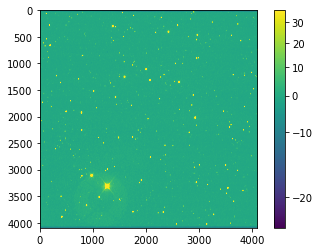

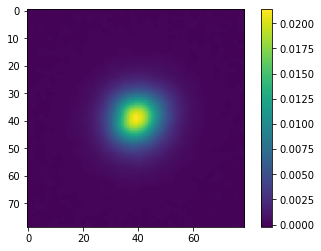

C:\ProgramData\Anaconda3\lib\site-packages\photutils\psf\models.py:721: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\ProgramData\Anaconda3\lib\site-packages\photutils\psf\models.py:721: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\ProgramData\Anaconda3\lib\site-packages\photutils\psf\models.py:723: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\ProgramData\Anaconda3\lib\site-packages\photutils\psf\models.py:723: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Solving.................................................

In [10]:
t0 = t.perf_counter()
filenames, epochid = np.loadtxt('../Epochs_V.csv', unpack=True, delimiter=',', usecols=(0,1), dtype='U100,f')
nepochs = np.int(np.max(epochid))
plot_residuals = input('Plot residuals? [y/n] ')
for i in range(58,59):#, nepochs+1):
    images = filenames[(epochid == i)]
    x = np.str(images[0])
    set_name = x[:22]
    path = '../fits/'
    im_data, headers = import_images(im_list=images, p=path)
    im_copy = copy.deepcopy(im_data[0])
    fwhm, im_sig = find_fwhm(image=im_copy, size=100)
    median_image = image_combiner(im_data=im_data, im_sig=im_sig)
    if median_image is None:
        image = im_data[0]
        print('No stars were detected in this image set.')
        pp = PdfPages('./results/'+set_name+'_'+np.str(i)+'nostars.pdf')
        for i in range(len(im_data)):
            fig, ax = plt.subplots(1, figsize=(10, 10))
            norm = ImageNormalize(im_data[i], interval=ZScaleInterval(), stretch=SqrtStretch())
            im = ax.imshow(im_data[i], norm=norm)
            plt.colorbar(im)
            plt.tight_layout()
            pp.savefig()
            plt.close()
        pp.close()
    else:
        image = median_image
        mean_val, median_val, std_val = sigma_clipped_stats(image, sigma=2.0)
        image -= median_val
        norm = ImageNormalize(image,interval=ZScaleInterval(),stretch=SqrtStretch())
        plt.imshow(image, norm=norm)
        plt.colorbar()
        plt.show()
        stars_tbl = Table()
        t1 = t.perf_counter()
        sources = find_stars(image=image, sigma=im_sig)
        t2 = t.perf_counter()
        stars_tbl = image_mask(image=image, sources=sources, fwhm=fwhm, bkg=median_val, bkg_std=std_val)
        image_lbs = bkg_sub(image=image, stars_tbl=stars_tbl, fwhm=fwhm)
        epsf, stars, fitted_stars = build_psf(image=image_lbs, stars_tbl=stars_tbl, fwhm=fwhm)
        plt.imshow(epsf.data)
        plt.colorbar()
        plt.show()
        t3 = t.perf_counter()
        if len(stars_tbl) <= 10 or fwhm > 30:
            print('FAILED!')
            results = []
            write_pdf_f(name='../results/'+set_name+'_'+np.str(i)+'.pdf', images=im_data, stars=stars, model=epsf.data, plot_res=plot_residuals)
            write_txt_f(name='../results/'+set_name+'_'+np.str(i)+'_diag.txt', sources=sources, stars_tbl=stars_tbl, fwhm=fwhm)
        else:
            results, photometry = do_photometry(image=image, epsf=epsf, fwhm=fwhm)
            results_tbl, residual_stars, final_stars = get_residuals(results=results, photometry=photometry, fwhm=fwhm, image=image)
            results.sort('flux_fit', reverse=True)
            t4 = t.perf_counter()
            sky, wcs_header = get_wcs(results_tbl=results_tbl)
            t5 = t.perf_counter()
            avg_airmass, bjd, header = write_fits(fn='../results/'+set_name+'_'+np.str(i)+'.fits', data=image, im_headers=headers, wcs_header=wcs_header)
            write_pdf(name='../results/'+set_name+'_'+np.str(i)+'.pdf', images=im_data, model=epsf.data, final_stars=final_stars, residual_stars=residual_stars, fluxes=results_tbl['flux'], plot_res=plot_residuals)
            write_csv(name='../results/'+set_name+'_'+np.str(i)+'.csv', im_name=set_name+'_'+np.str(i), bjd=bjd[0], filt=header['FILTER'], airmass=avg_airmass, results=results)
            write_txt(name='../results/'+set_name+'_'+np.str(i)+'_diag.txt', sources=sources, stars_tbl=stars_tbl, results=results, fwhm=fwhm,t0=t0,t1=t1,t2=t2,t3=t3,t4=t4,t5=t5)